In [ ]:
!apt install subversion
!mkdir data
!svn checkout https://github.com/ChanCheeKean/datasets/trunk/nlp data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, re, itertools, random
import nltk, spacy
from keras.preprocessing import sequence, text
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, LSTM, add, dot, concatenate

Material:

Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush, "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks", http://arxiv.org/abs/1502.05698

Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus, "End-To-End Memory Networks", http://arxiv.org/abs/1503.08895

# 1) Pre-Processing

In [ ]:
def vectorizer(data):
    # split into stories, questions and answer
    story = [[word.lower() for word in sent[0]] for sent in data]
    question = [[word.lower() for word in sent[1]] for sent in data]
    answers = [sent[2].lower() for sent in data]
    
    # tokenized the text
    story_seq = tokenizer.texts_to_sequences(story)
    questions_seq = tokenizer.texts_to_sequences(question)

    # padding
    inputs = sequence.pad_sequences(story_seq, maxlen=max_story_len)
    queries = sequence.pad_sequences(questions_seq, maxlen=max_question_len)
    output = np.array([0 if x =='no' else 1 for x in answers])
    
    return inputs, queries, output

In [ ]:
with open("./data/train_qa.txt", "rb") as fp:
    train_data =  pickle.load(fp)

with open("./data/test_qa.txt", "rb") as fp:
    test_data =  pickle.load(fp)

# see the shape
all_data = np.vstack([test_data, train_data])
all_data.shape

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(11000, 3)

In [ ]:
stories = [x[0] for x in all_data]
questions = [x[1] for x in all_data]
answers = [x[2] for x in all_data]

print(' '.join(stories[0]))
print(' '.join(questions[0]))
print(''.join(answers[0]))

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?
no


In [ ]:
# tokenized the text
tokenizer = text.Tokenizer(filters=[])
tokenizer.fit_on_texts(stories + questions)

# add an extra space to hold a 0 for Keras's pad_sequences
max_story_len = max([len(x) for x in stories])
max_question_len = max([len(x) for x in questions])

In [ ]:
# train data, split into stories, questions and answers
trained_inputs, trained_queries, trained_output = vectorizer(train_data)
test_inputs, test_queries, test_output = vectorizer(train_data)

# 2) Model Architecture

In [ ]:
class Transformer(Model):
    def __init__(self, vocab_size, nb_classes=2, dropout_rate=0.1, training=False):
        super(Transformer, self).__init__(name="transformer")
        
        # embed the inputs into a sequence of vectors
        self.input_encoder_m = Sequential()
        self.input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64)) 
        self.input_encoder_m.add(Dropout(dropout_rate))
        
        # embed the inputs into a sequence of vectors of size query_maxlen
        self.input_encoder_c = Sequential()
        self.input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
        self.input_encoder_c.add(Dropout(dropout_rate))
        
        # embed the questions into a sequence of vectors
        self.question_encoder = Sequential()
        self.question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
        self.question_encoder.add(Dropout(dropout_rate))
        
        self.activation = Activation('softmax')
        self.permute = Permute((2, 1))
        self.lstm = LSTM(32)
        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(nb_classes)
        
    def call(self, inputs, training):
        # encode input sequence and questions (which are indices) to sequences of dense vectors
        input_encoded_m = self.input_encoder_m(inputs[0])
        input_encoded_c = self.input_encoder_c(inputs[0])
        question_encoded = self.question_encoder(inputs[1])
        
        match = dot([input_encoded_m, question_encoded], axes=(2, 2))
        match = self.activation(match)
        
        # add the match matrix with the second input vector sequence
        response = add([match, input_encoded_c])
        response = self.permute(response)
        
        # Reduce with RNN (LSTM)
        answer = concatenate([response, question_encoded])
        answer = self.lstm(answer)

        # Regularization with Dropout
        answer = self.dropout(answer)
        answer = self.dense(answer)

        # we output a probability distribution over the vocabulary
        answer = self.activation(answer)
        return answer

V = len(tokenizer.word_index) + 1
NB_CLASSES = len(np.unique(trained_output))
DROPOUT_RATE = 0.3

transformer_model = Transformer(vocab_size=V, nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE)
transformer_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = transformer_model.fit([trained_inputs, trained_queries], trained_output, batch_size=32, epochs=50,
                                validation_data=([test_inputs, test_queries], test_output))

Epoch 1/50
313/313 [==============================] - 9s 20ms/step - loss: 0.6997 - accuracy: 0.4964 - val_loss: 0.6934 - val_accuracy: 0.4988
Epoch 2/50
313/313 [==============================] - 6s 19ms/step - loss: 0.6938 - accuracy: 0.5083 - val_loss: 0.6930 - val_accuracy: 0.5137
Epoch 3/50
313/313 [==============================] - 6s 19ms/step - loss: 0.6934 - accuracy: 0.5007 - val_loss: 0.6929 - val_accuracy: 0.5155
Epoch 4/50
313/313 [==============================] - 6s 19ms/step - loss: 0.6934 - accuracy: 0.4940 - val_loss: 0.6944 - val_accuracy: 0.5012
Epoch 5/50
313/313 [==============================] - 6s 18ms/step - loss: 0.6940 - accuracy: 0.4940 - val_loss: 0.6928 - val_accuracy: 0.5032
Epoch 6/50
313/313 [==============================] - 6s 18ms/step - loss: 0.6927 - accuracy: 0.5119 - val_loss: 0.6919 - val_accuracy: 0.5213
Epoch 7/50
313/313 [==============================] - 6s 19ms/step - loss: 0.6920 - accuracy: 0.5225 - val_loss: 0.6885 - val_accuracy: 0.5280

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


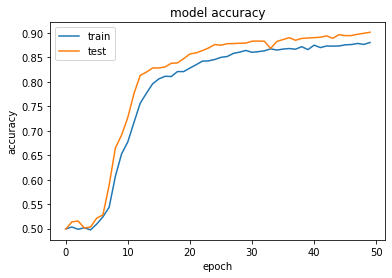

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_inputs.shape

(10000, 156)

In [ ]:
rand = random.randint(0, len(test_inputs))
story = ' '.join(tokenizer.index_word.get(word) for word in test_inputs[rand] if word != 0)
print(story)
query = ' '.join(tokenizer.index_word.get(word) for word in test_queries[rand] if word != 0)
print(query)
print(f"True Answer: {test_output[rand]} \n")

pred_results = transformer_model.predict(([test_inputs, test_queries]))
result = pred_results[rand].argmax()
print(f"Predicted Answer is {result}!")
print("Probability of certainty was: ", pred_results[rand].max())

sandra got the milk there . john went to the garden . sandra travelled to the hallway . sandra discarded the milk .
is sandra in the bathroom ?
True Answer: 0 

Predicted Answer is 0!
Probability of certainty was:  0.99998844


In [ ]:
# create own queries
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_question = "Is Sandra in the garden?"
mydata = [(my_story.split(), my_question.split(), 'yes')]
my_story, my_ques, my_ans = vectorizer(mydata)
pred_result = transformer_model.predict(([my_story, my_ques])).argmax()
print(f"Predicted Answer is {pred_result}!")

Predicted Answer is 1!
